## Global Imports

In [104]:
import numpy as np
# import seaborn as sns
# sns.set(color_codes=True)
import matplotlib.pyplot as plt
import pandas as pd

from numpy.random import seed
seed(10)
# set_random_seed(10)

## Load Data

In [105]:
!ls

Final_dataset.csv  gdrive  sample_data


In [106]:
fileName = 'Final_dataset.csv'
dataset = pd.read_csv(fileName, header=None, engine='python')
dataset.shape

(26673, 211)

In [107]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,25.0,-7.6200,25.0,-4.070,10.70,25.0,-2.06,1.860,15.2,25.0,...,-12.00,18.4,10.10,-3.84,-10.10,6.920,3.37,9.05,25.0,1
1,25.0,-10.2000,25.0,-11.200,11.20,25.0,-6.07,3.550,16.3,25.0,...,-17.10,18.2,20.40,-11.60,-13.90,8.020,6.08,16.00,25.0,1
2,25.0,-5.7900,25.0,2.110,9.63,25.0,1.36,4.580,20.4,25.0,...,-13.70,19.4,6.51,-5.10,-4.98,7.310,-3.83,1.25,25.0,1
3,25.0,-1.4900,25.0,-0.941,8.97,25.0,-2.13,1.880,16.0,25.0,...,-9.01,17.2,8.98,-6.04,-11.20,-0.559,6.83,5.77,25.0,1
4,25.0,-0.0711,25.0,-4.850,9.32,25.0,-5.97,-0.816,16.4,25.0,...,-10.70,16.6,12.90,-4.73,-7.83,5.500,-0.98,3.73,25.0,1


In [108]:
dataset.isnull().any().any()

True

In [109]:
dataset.fillna(1, inplace=True)

In [110]:
dataset.isnull().any().any()

False

In [111]:
shortCol = []
columns = dataset.columns.tolist()
for i in columns:
  if(dataset[i].nunique() != 1):
    shortCol.append(i)
    #print(i, ": ", dataset[i].nunique())

In [112]:
ttl_data = dataset.iloc[:, shortCol].values
np.random.shuffle(ttl_data)
ttl_data.shape

(26673, 211)

In [113]:
ttl_data[ttl_data[:, -1] == 1].shape

(12646, 211)

In [114]:
ttl_data[ttl_data[:, -1] == 0].shape

(14027, 211)

## Separate Positives & Negatives

In [115]:
pos = ttl_data[ttl_data[:, -1] == 1]
np.random.shuffle(pos)
neg = ttl_data[ttl_data[:, -1] == 0]
np.random.shuffle(neg)

## Train-Test Split

In [116]:
tstSize = 5335
p_test, p_train = pos[0:tstSize, ...], pos[tstSize:, ...]
n_test, n_train = neg[0:tstSize, ...], neg[tstSize:, ...]
train, test = np.vstack((p_train, n_train)), np.vstack((p_test, n_test))
np.random.shuffle(train)
np.random.shuffle(test)
X_train, X_test, y_train, y_test = train[:, :-1], test[:, :-1], train[:, -1], test[:, -1]

In [117]:

print(y_train.shape)
print(y_train[y_train == 1].shape)
print(y_train[y_train == 0].shape)

print('-'*60)

print(y_test.shape)
print(y_test[y_test == 1].shape)
print(y_test[y_test == 0].shape)

(16003,)
(7311,)
(8692,)
------------------------------------------------------------
(10670,)
(5335,)
(5335,)


## Scaling Data

In [118]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Balance Data

In [119]:
# from imblearn.combine import SMOTEENN 
# X_train_res, y_train_res = SMOTEENN(sampling_strategy='auto', random_state=42).fit_resample(X_train, y_train)

In [120]:
from imblearn.combine import SMOTETomek
X_train_res, y_train_res = SMOTETomek(random_state=42).fit_resample(X_train, y_train)

In [121]:
# from imblearn.under_sampling import ClusterCentroids
# X_train_res, y_train_res = ClusterCentroids(sampling_strategy='auto', random_state=None, estimator=None, voting='auto', n_jobs='deprecated').fit_resample(X_train, y_train)

In [122]:
# from collections import Counter
# from sklearn.datasets import make_classification
# from imblearn.under_sampling import NearMiss 

# X_train_res, y_train_res = NearMiss(sampling_strategy='auto', version=1, n_neighbors=3, n_neighbors_ver3=3, n_jobs=None).fit_resample(X_train, y_train)


In [123]:
# from imblearn.over_sampling import SVMSMOTE
# X_train_res, y_train_res = SVMSMOTE().fit_resample(X_train, y_train)

In [124]:
# from imblearn.under_sampling import TomekLinks
# tl = TomekLinks(sampling_strategy='all')
# X_train_res, y_train_res = tl.fit_resample(X_train_res, y_train_res)

In [125]:
print(y_train_res.shape)
print(y_train_res[y_train_res == 1].shape)
print(y_train_res[y_train_res == 0].shape)

(16408,)
(8204,)
(8204,)


## Trial SVM

In [126]:
from sklearn.svm import SVC, SVR
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
#kernel = 1.0 * RBF(1.0)
regr = SVC(kernel='rbf', gamma='scale')
#regr = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0))
#regr = GaussianProcessClassifier(kernel=kernel,random_state=0)
regr.fit(X_train_res, y_train_res)

y_pred = regr.predict(X_test)
y_pred = np.where(y_pred > 0.50, 1, 0)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

print('-'*60)

clf = SVC(kernel='rbf', gamma='scale')
#clf = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0))
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)


accuracy:  0.825866916588566

f1_score:  0.802927450148494

Confusion Matrix
[[5027  308]
 [1550 3785]]
------------------------------------------------------------
accuracy:  0.825866916588566

f1_score:  0.802927450148494

Confusion Matrix
[[5027  308]
 [1550 3785]]


##MLP neural_network

In [127]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(alpha=1, max_iter=1000)
#clf = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1)
clf.fit(X_train, y_train)


from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())



***CROSS VALIDATION***
[0.85191956 0.83302864 0.84399756 0.84887264 0.83546618 0.84277879
 0.8464351  0.84338818 0.84207317 0.8445122 ]
accuracy:  0.8432472020332634
0.005345673314622949


In [128]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.8227741330834114

f1_score:  0.7957662814558807

Confusion Matrix
[[5095  240]
 [1651 3684]]


##ExtraTrees

In [129]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
clf.fit(X_train_res, y_train_res)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())

***CROSS VALIDATION***
[0.85252895 0.84399756 0.85009141 0.84034126 0.84399756 0.8543571
 0.84765387 0.84521633 0.88597561 0.91463415]
accuracy:  0.8578793790223094
0.02251687621090419


In [130]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.8074976569821931

f1_score:  0.7788068059444324

Confusion Matrix
[[5000  335]
 [1719 3616]]


##SVM (rbf)


In [131]:
from sklearn.svm import SVC, SVR

classifier = SVC(kernel='rbf', gamma='scale')
#classifer = SVC(kernel='rbf', probability=True, C=1.0, gamma='scale')
classifier.fit(X_train_res, y_train_res)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())

***CROSS VALIDATION***
[0.84521633 0.82998172 0.85070079 0.84826325 0.83973187 0.84582572
 0.83912249 0.84156002 0.84573171 0.85121951]
accuracy:  0.8437353413296472
0.0060562458881215945


In [132]:
y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.825866916588566

f1_score:  0.802927450148494

Confusion Matrix
[[5027  308]
 [1550 3785]]


##XGBOOST

In [133]:
from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor

clf = XGBClassifier()
clf.fit(X_train_res, y_train_res)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())

print('-'*60)

***CROSS VALIDATION***
[0.84460695 0.82815356 0.84826325 0.84399756 0.83180987 0.83241926
 0.83120049 0.84338818 0.83963415 0.84512195]
accuracy:  0.8388595220047265
0.0068748980296002
------------------------------------------------------------


In [134]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.819962511715089

f1_score:  0.798869228353052

Confusion Matrix
[[4934  401]
 [1520 3815]]


##Random Forest

In [135]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=300)
clf.fit(X_train_res, y_train_res)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_res, y = y_train_res, cv = 10, scoring='accuracy')
print("***CROSS VALIDATION***")
print(accuracies)
print("mean.accuracy: ", accuracies.mean())
print(accuracies.std())


***CROSS VALIDATION***
[0.75563681 0.75746496 0.77757465 0.78123096 0.77026204 0.75624619
 0.76904327 0.77391834 0.77256098 0.77987805]
mean.accuracy:  0.7693816233409135
0.009234465068130223


In [136]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.748734770384255

f1_score:  0.6644135686569033

Confusion Matrix
[[5335    0]
 [2681 2654]]


##LightGBM

In [137]:
from lightgbm import LGBMRegressor, LGBMClassifier

clf = LGBMClassifier(num_leaves=31, n_estimators=40, learning_rate=0.1)
clf.fit(X_train_res, y_train_res)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())

***CROSS VALIDATION***
[0.84338818 0.82937233 0.85252895 0.85009141 0.83729433 0.83729433
 0.83790372 0.84338818 0.85792683 0.85243902]
accuracy:  0.8441627279618317
0.008465051346552429


In [138]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.8230552952202437

f1_score:  0.803497085761865

Confusion Matrix
[[4922  413]
 [1475 3860]]


## Init Scorers

In [139]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef
from imblearn.metrics import sensitivity_score, specificity_score

curves = []

def plt_curve(lst, name):
  plt.figure(figsize=(20,10))
  
  for idx, itm in enumerate(lst):
    fpr, tpr = itm
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (idx+1, auc(fpr, tpr)))
    
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

def roc_plt(y_true, y_score):
  fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
  curves.append([fpr, tpr])
  return 1

metrs = {
         'roc_plt': make_scorer(roc_plt, needs_proba=True), 
         'matthews_corrcoef': make_scorer(matthews_corrcoef), 
         'sensitivity_score': make_scorer(sensitivity_score), 
         'specificity_score': make_scorer(specificity_score)
        }

## SVM CV Scores

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 298, in _score
    y_pred = method_caller(clf, "predict_proba", X)
  File "/usr/local/lib/python3.7/dist-

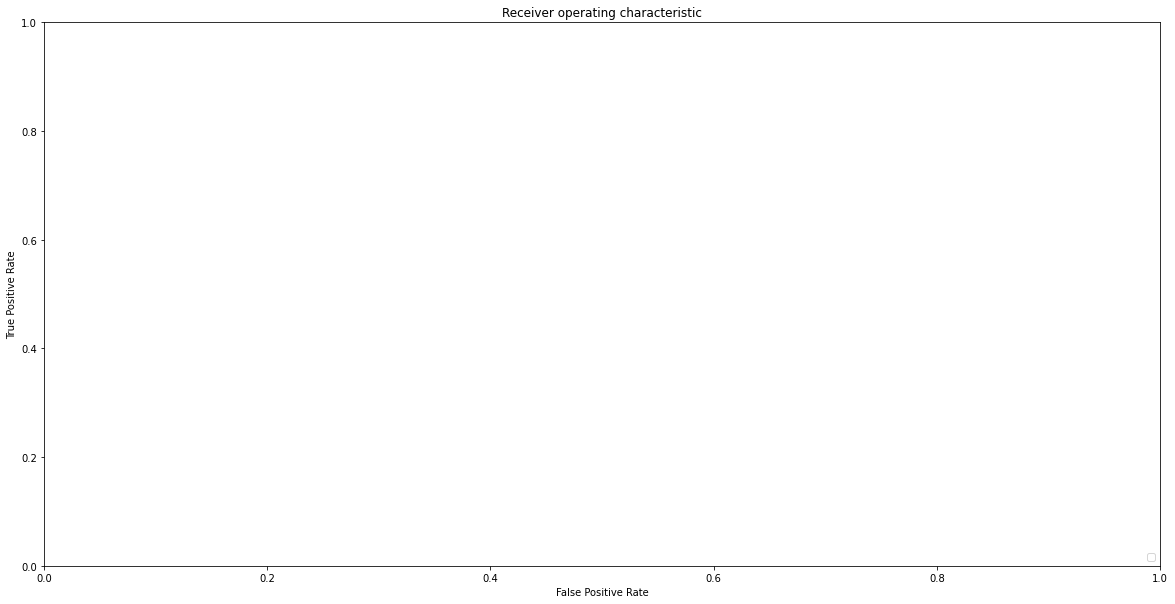

***CROSS VALIDATION***
SVM


{'fit_time': array([30.40463281, 29.45253015, 29.27775979, 28.62993741, 30.26079416,
        30.30755019, 28.90865874, 28.71621847, 30.30112457, 30.76581025]),
 'score_time': array([0.00286484, 0.00096345, 0.00085068, 0.00083375, 0.00111008,
        0.00083852, 0.00108194, 0.00168276, 0.00176692, 0.00180602]),
 'test_matthews_corrcoef': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'test_roc_plt': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'test_sensitivity_score': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'test_specificity_score': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}

<Figure size 720x504 with 0 Axes>

In [140]:
from sklearn.svm import SVC, SVR
classifier = SVC(kernel='rbf', gamma='scale')


curves = []

scores = cross_validate(classifier, 
                        X_train_res, 
                        y_train_res, 
                        cv=10,
                        scoring=metrs,
                        return_train_score=False)

plt_curve(curves, "SVM CV")
plt.figure(figsize=(10,7))
print("***CROSS VALIDATION***")
print("SVM")
scores
#scores['roc']=curves

## Cross Validation and Independent Test for (SVM)

In [141]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef, precision_recall_curve, average_precision_score
from imblearn.metrics import sensitivity_score, specificity_score
from scipy import interp

tprs = []
def plt_curve(lst, name):
  plt.figure(figsize=(20,10))
  
  for idx, itm in enumerate(lst):
    fpr, tpr = itm
    tprs.append(interp(np.linspace(0, 1, 100), fpr, tpr))
    tprs[-1][0] = 0.0
#     plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (idx+1, auc(fpr, tpr)))
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
         label='Random Guess', alpha=.8)
  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(np.linspace(0, 1, 100), mean_tpr)
  std_auc = np.std(aucs)
  plt.plot(mean_fpr, mean_tpr, color='b',
         label='% fold cross validation (AUC = %0.2f)' % (mean_auc),
         lw=2, alpha=.8)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

  
  
def roc_plt(y_true, y_score):
  fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
  curves.append([fpr, tpr])
  return 1

def pr_curve(lst, apLst, name):
  plt.figure(figsize=(20,10))
  
  f_scores = np.linspace(0.2, 0.8, num=4)
  for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.7, y[36] + 0.02))
  
  for idx, itm in enumerate(lst):
    pre, rec = itm
    plt.plot(pre, rec, lw=1, label='Precision-Recall fold %d (AP = %0.2f)' % (idx+1, apLst[idx]))
    
  plt.ylim([0.0, 1.0])
  plt.xlim([0.0, 1.0])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

  
  
def pr_plt(y_true, y_score):
  precision, recall, _ = precision_recall_curve(y_true, y_score, pos_label=1)
  pr_curves.append([precision, recall])
  return 1

metrs = {
         'roc_plt': make_scorer(roc_plt, needs_proba=True), 
         'pr_plt': make_scorer(pr_plt, needs_proba=True), 
         'average_precision': make_scorer(average_precision_score, needs_proba=True), 
         'matthews_corrcoef': make_scorer(matthews_corrcoef), 
         'sensitivity_score': make_scorer(sensitivity_score), 
         'specificity_score': make_scorer(specificity_score)
        }

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 298, in _score
    y_pred = method_caller(clf, "predict_proba", X)
  File "/usr/local/lib/python3.7/dist-

TypeError: ignored

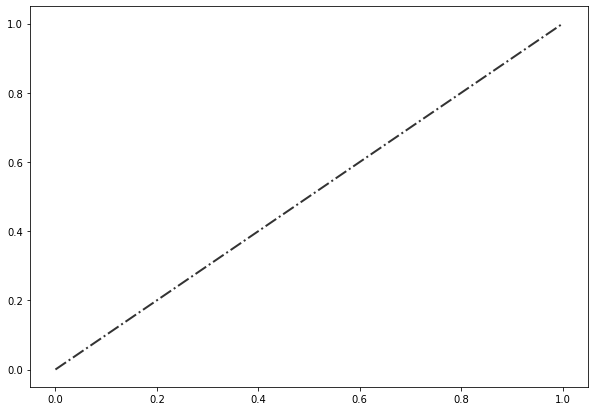

In [143]:
from sklearn.svm import SVC, SVR
classifier = SVC(kernel='rbf', gamma='scale')

curves = []
pr_curves = []

scores = cross_validate(classifier, 
                        X_train_res, 
                        y_train_res, 
                        cv=10,
                        scoring=metrs,
                        return_train_score=False)


tprs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,7))

for idx, itm in enumerate(curves):
  fpr, tpr = itm
  tprs.append(interp(mean_fpr, fpr, tpr))
  tprs[-1][0] = 0.0
#     plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (idx+1, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], linestyle='-.', lw=2, color='black',
       label='Random Guess', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b',
       label='10 fold cross validation (AUC = %0.2f)' % (mean_auc),
       lw=2, alpha=.8)
classifier.fit(X_train_res, y_train_res)
y_pred = classifier.predict(X_test)
y_score = classifier.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label=1)
plt.plot(fpr, tpr, lw=2, color='r', label='Independent test (AUC = %0.2f)' % (auc(fpr, tpr)))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
figName = "SVM ROC(Cross val and Independent)" + '.png'
plt.savefig(figName, bbox_inches='tight')
plt.show()


#plt_curve(curves, "SVM ROC CV")
#pr_curve(pr_curves, scores['test_average_precision'], "SVM PR CV")
#scores
#scores['roc']=curves

# Feature Importance

In [144]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Elapsed time to compute the importances: 5.940 seconds


NameError: ignored

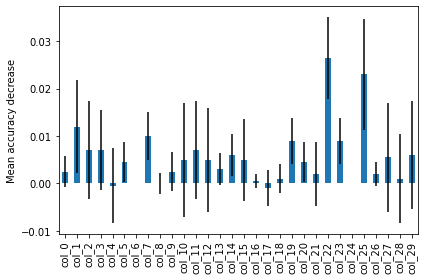

In [145]:
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=1000,
    n_features=30,
    n_informative=10,
    n_redundant=5,
    n_repeated=15,
    n_classes=2,
    random_state=0,
    shuffle=True,
)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=0)

feature_names = [f"col_{i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=42, max_depth=2)
forest.fit(X_train, y_train)

start_time = time.time()
result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.xticks(range(X_train.shape[1]), ["col_"+str(i) for i in indices])
from matplotlib.pyplot import figure
fig.set_size_inches(8, 5, forward=True)
#plt.savefig("Feature Importance", bbox_inches='tight')
images_dir = '/content/gdrive/My Drive/Images'
plt.savefig(f"{images_dir}/Feature Importances using Permutation.png")
plt.show()